In [1]:
import os
import glob
import datetime

from netCDF4 import Dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

2024-08-20 20:32:39.254511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 20:32:39.268898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 20:32:39.274316: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 20:32:39.284909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 20:32:40.166711: W tensorflow/compiler/tf2

## Input Data

In [2]:
ds = xr.open_dataset("../data/cwt_no_overlap_60s_mexh.nc")
ds

<xarray.Dataset> Size: 64MB
Dimensions:   (samples: 3936, frequency: 127, time: 127)
Dimensions without coordinates: samples, frequency, time
Data variables:
    features  (samples, frequency, time) uint8 63MB ...
    labels    (samples) int64 31kB ...

In [3]:
X_train, X_test, y_train, y_test = train_test_split(ds["features"].to_numpy(), ds["labels"].to_numpy(), test_size=0.33, random_state=22, stratify=ds["labels"])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2637, 127, 127), (1299, 127, 127), (2637,), (1299,))

In [4]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(X_train.shape[0]).batch(8).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(X_test.shape[0]).batch(8).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1724160761.493102   95664 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724160761.525616   95664 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724160761.525678   95664 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724160761.528465   95664 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724160761.528582   95664 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

## Create Model

In [26]:
inputs = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same")(inputs)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

# x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same")(x)
# x = tf.keras.layers.Activation("relu")(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

# x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [27]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 127, 127, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 127, 127, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 63, 63, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,385 (173.38 KB)

 Trainable params: 44,385 (173.38 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # loss=tf.keras.losses.BinaryFocalCrossentropy(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])

In [29]:
log_dir = "logs/fit/" + "cwt_mexh-cnn_3-stride2-no_ovr_60s-pool_max" #datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=[tensorboard_callback])
# model.fit(train_ds, epochs=100, validation_data=test_ds)

Epoch 1/100


330/330 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6857 - auc: 0.4999 - fn: 11.8338 - fp: 409.5468 - loss: 0.8210 - prc: 0.7068 - precision: 0.6976 - recall: 0.9736 - tn: 3.9486 - tp: 902.6284 - val_accuracy: 0.6828 - val_auc: 0.5367 - val_fn: 0.0000e+00 - val_fp: 412.0000 - val_loss: 0.6258 - val_prc: 0.7148 - val_precision: 0.6828 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 887.0000
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6837 - auc: 0.5024 - fn: 0.0000e+00 - fp: 421.6616 - loss: 0.6254 - prc: 0.6873 - precision: 0.6837 - recall: 1.0000 - tn: 0.0000e+00 - tp: 906.2961 - val_accuracy: 0.6828 - val_auc: 0.5171 - val_fn: 0.0000e+00 - val_fp: 412.0000 - val_loss: 0.6243 - val_prc: 0.7099 - val_precision: 0.6828 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 887.0000
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6768 - auc: 0.5120 - fn: 0.0000e+00 - fp: 427.8761 - loss: 0.6297 - prc: 0.6954 - precision: 0.6768 - recall: 

KeyboardInterrupt: 

In [ ]:
model.export("../data/models/cwt_mexh-cnn_3-global_avg")

INFO:tensorflow:Assets written to: ../data/models/cwt_mexh-cnn_2-global_avg/assets


INFO:tensorflow:Assets written to: ../data/models/cwt_mexh-cnn_2-global_avg/assets


Saved artifact at '../data/models/cwt_mexh-cnn_2-global_avg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 127, 127, 1), dtype=tf.float32, name='keras_tensor_7')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139874012590528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139874012590880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139874012644272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139874012647264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139874012651136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139874012653424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139874012653952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139874012656240: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Evaluate

In [ ]:
model.evaluate(test_ds)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9188 - auc: 0.9749 - fn: 5.1707 - fp: 49.1585 - loss: 0.2105 - prc: 0.9872 - precision: 0.8997 - recall: 0.9884 - tn: 165.9390 - tp: 439.6219


[0.20666588842868805,
 878.0,
 101.0,
 311.0,
 9.0,
 0.9153195023536682,
 0.8968334794044495,
 0.9898534417152405,
 0.9744680523872375,
 0.9876894354820251]

In [ ]:
y_pred = model.predict(X_test) > 0.5

print("MCC:", np.round(matthews_corrcoef(y_test, y_pred), 4))
print("Accuracy:", np.round(accuracy_score(y_test, y_pred), 4))
print("Precision:", np.round(precision_score(y_test, y_pred), 4))
print("Recall:", np.round(recall_score(y_test, y_pred), 4))
print("F1:", np.round(f1_score(y_test, y_pred), 4))

print(classification_report(y_test, y_pred))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
MCC: 0.8043
Accuracy: 0.9153
Precision: 0.8968
Recall: 0.9899
F1: 0.9411
              precision    recall  f1-score   support

           0       0.97      0.75      0.85       412
           1       0.90      0.99      0.94       887

    accuracy                           0.92      1299
   macro avg       0.93      0.87      0.90      1299
weighted avg       0.92      0.92      0.91      1299



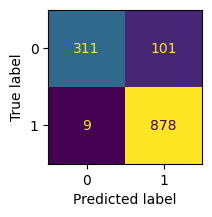

In [ ]:
fig, ax = plt.subplots(figsize=(2, 2))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)